In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
def connectBallAndPost(cnt, balls):
    if len(balls) == 0:
        return False
    
    cnt_np = np.zeros([4,2])
    cnt_np[0,:] = cnt[0]
    cnt_np[1,:] = cnt[1]
    cnt_np[2,:] = cnt[2]
    cnt_np[3,:] = cnt[3]
    
    # Find top of post
    first_i_miny = np.argmin(cnt_np[:,1])
    first_min_xy = cnt_np[first_i_miny,:].copy()
    cnt_np[first_i_miny,1] = 99999 # temporarily override min
    second_i_miny = np.argmin(cnt_np[:,1])
    second_min_xy = cnt_np[second_i_miny,:].copy()
    cnt_np[first_i_miny,1] = first_min_xy[1] # restore min
    
    post_topcenter = [(first_min_xy[0]+second_min_xy[0])/2.0, (first_min_xy[1]+second_min_xy[1])/2.0]
    
    # Is a red ball nearby
    foundMatch = False
    for ball in balls:
        center = ball[1]
        radius = ball[0]
        dist_x = post_topcenter[0]-center[0]
        dist_y = post_topcenter[1]-center[1]
        d = sqrt(dist_x*dist_x + dist_y*dist_y)
        box_y_center = cnt_np[3,1]-post_topcenter[1]
        if (d < 2*radius) and (box_y_center > center[1]):
            foundMatch = True
            break
    
    return foundMatch
        

1815.0


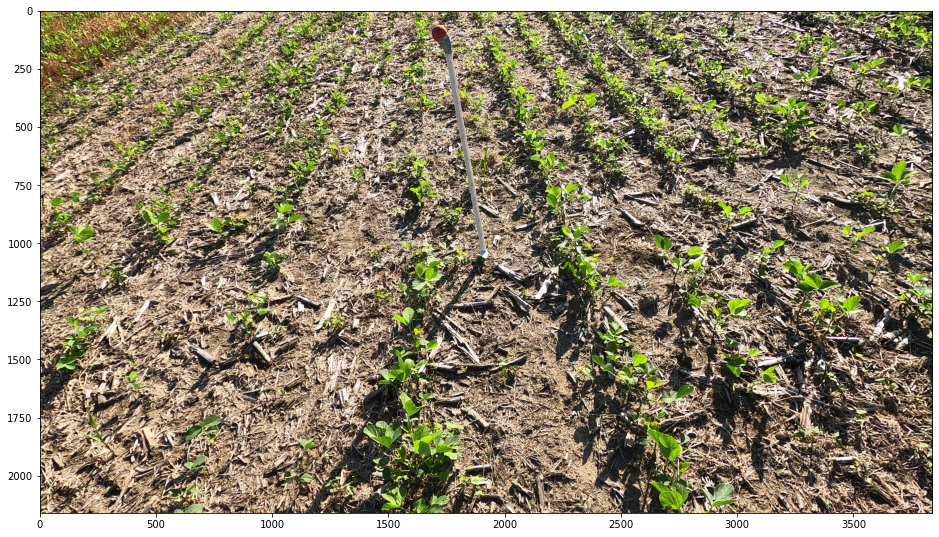

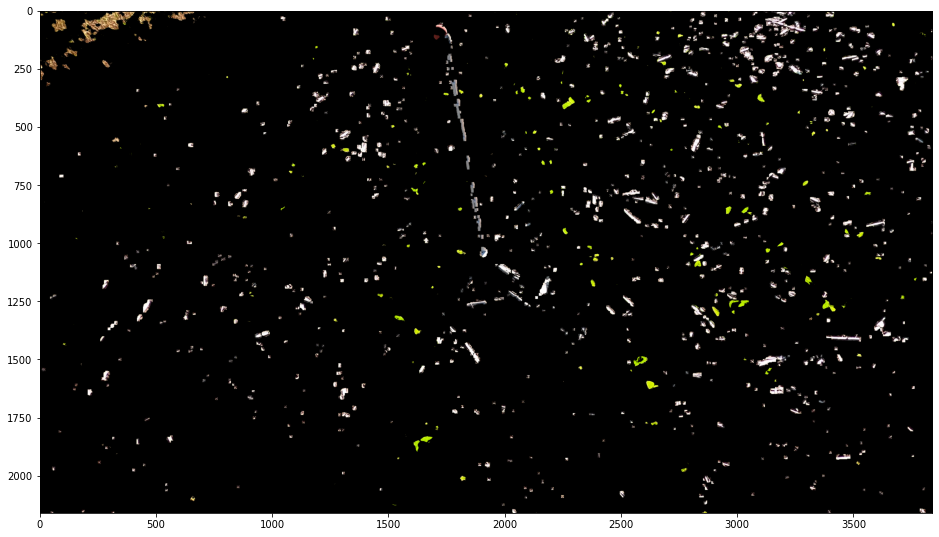

In [3]:
#filepath = '.\\data\\TX-COTTON1-1-CALIB-COTTON1-GX010031.MP4'
#filepath = '.\\data\\Calib-test.MP4'
filepath = '.\\data\\DE-C5D-1-CALIB-FIELD 7-GX010085.MP4'

cap = cv2.VideoCapture(filepath)
while not cap.isOpened():
    cap = cv2.VideoCapture(filepath)
    cv2.waitKey(1000)
    print("Wait for the header")

pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
print(cap.get(cv2.CAP_PROP_FRAME_COUNT))

count = 0
empty = 0
#for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):



for i in range(1):
    ret, frame = cap.read()
    if ret == True:
        count += 1
    else:
        empty += 1

b = cv2.medianBlur(frame[:,:,0],11)
g = cv2.medianBlur(frame[:,:,1],11)
r = cv2.medianBlur(frame[:,:,2],11)

#2R-G-B
ExR = 2*r.astype('int') - b.astype('int') - g.astype('int')
ExW = r.astype('int') + b.astype('int') + g.astype('int')


#HLS
BGR = frame.copy()
#BGR[:,:,0] = b
#BGR[:,:,1] = g
#BGR[:,:,2] = r
HLS = cv2.cvtColor(BGR, cv2.COLOR_BGR2HLS)

# cutout mask
redMask = (ExR > 120).astype('uint8')
#whiteMask = (ExW > 650).astype('uint8')
hueMask = (HLS[:,:,0]>100).astype('uint8')
lightMask = (HLS[:,:,1]>150).astype('uint8')
whiteMask = np.bitwise_and(hueMask,lightMask).astype('uint8')

# dilation and erosion
kernel = np.ones((11, 11), np.uint8)
whiteMask = cv2.dilate(whiteMask, kernel, iterations=1)
#whiteMask = cv2.erode(whiteMask, kernel, iterations=1)

mask = np.bitwise_or(redMask,whiteMask).astype('uint8')
rows = np.shape(frame)[0]
cols = np.shape(frame)[1]
ExRW_img = np.zeros([rows,cols,3],dtype='uint8')

for c in range(3):
    ExRW_img[:,:,c] = np.multiply(frame[:,:,c],mask).astype('uint8')


ret,thresh = cv2.threshold(redMask,0,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
circle_data = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 1000:
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        center = (int(x),int(y))
        radius = int(radius)
        circle_mask = np.zeros([rows,cols],dtype='uint8')
        cv2.circle(circle_mask,center,radius,1,-1)
        pix = np.sum(np.bitwise_and(circle_mask,redMask))
        circle_area = np.sum(circle_mask)
        circle_fill = pix/circle_area
        if (circle_fill>=0.75):
            cv2.circle(frame,center,radius,(255,0,0),4)
            cv2.circle(ExRW_img,center,radius,(255,255,255),4)
            cv2.circle(whiteMask,center,radius,0,-1)
            circle_data.append((radius,center))
            
ret,thresh = cv2.threshold(whiteMask,0,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
box_data = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 2000:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        if connectBallAndPost(box, circle_data):
            cv2.drawContours(frame,[box],0,(255,0,0),2)
            #cv2.drawContours(ExRW_img,[box],0,(0,0,255),2)
            box_data.append(box)  
    

plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(ExRW_img,cv2.COLOR_BGR2RGB))
plt.show()

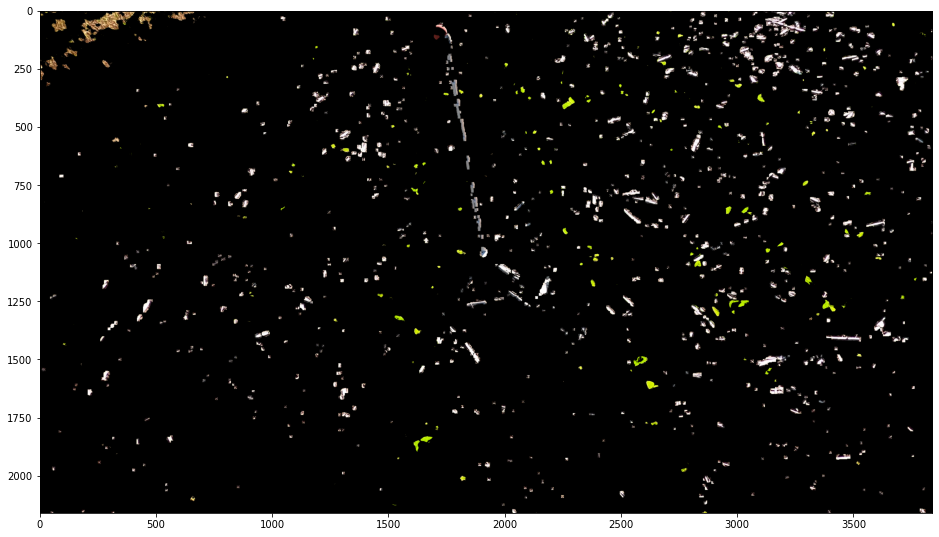

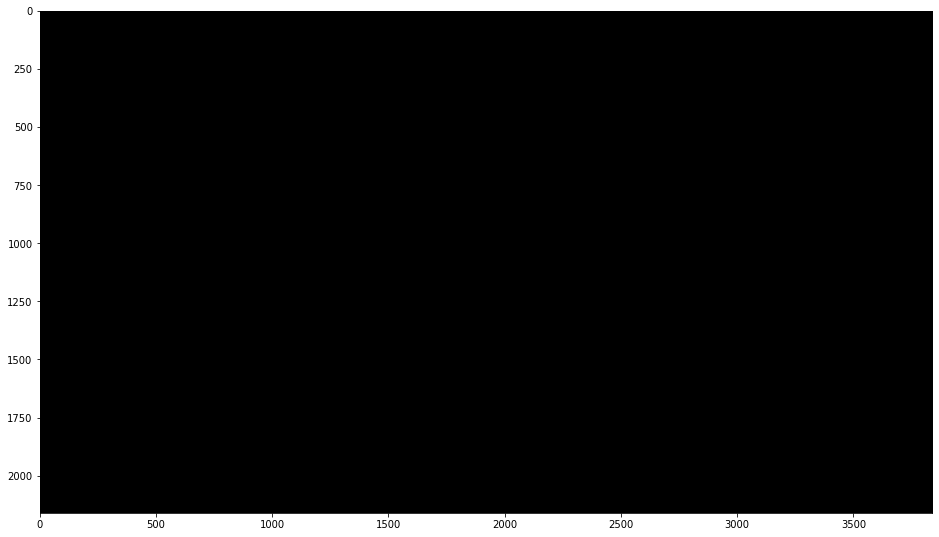

In [4]:
clipped_ExW = whiteMask.copy()
post_mask = np.zeros([np.shape(clipped_ExW)[0], np.shape(clipped_ExW)[1]], dtype=np.uint8)
for box in box_data:
    cv2.drawContours(post_mask,[box],0,1,-1)                  
    minm = np.min(box[:,1])
    maxm = np.max(box[:,1])
    minn = np.min(box[:,0])
    maxn = np.max(box[:,0])
    post_mask[minm:minm+50,minn:maxn] = 0
    post_mask[maxm-50:maxm,minn:maxn] = 0
    
for circle in circle_data:
    (radius, center) = circle
    cv2.circle(post_mask,center,radius,0,-1)

clipped_ExW = np.multiply(clipped_ExW, post_mask)
contours,hierarchy = cv2.findContours(clipped_ExW, 1, 2)
box_data = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 2000:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(ExRW_img,[box],0,(0,0,255),2)
        box_data.append(box)  

plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(ExRW_img,cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(clipped_ExW, cmap='gray')
plt.show()